# Tenure Data - Predictors Selection

## import packages and functions

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold 
import janitor
from IPython.display import display


In [2]:
print(os.getcwd())

/Users/yukachen/marketing-operation/tenure


Load Churned Lead Data

In [3]:
# load and clean data
churned_lead_brizo_zip = pd.read_csv('imported_data/churned_lead_brizo_zip.csv').clean_names()

In [4]:
display(churned_lead_brizo_zip.head(5))

,unique_code,density,density_band,expected_gmv_c,median_household_income,median_income_band,menu_type_c,cuisines_regional,cuisines_continental,population,population_band,region,school_zone,state_code,tenure_in_complete_months,zip_code
0,R85077,177,101 - 500,NaN,"$16,916","$1 - $60,000",Chinese-Unknown,NaN,NaN,6853,"5,001 - 20,000",Midwest,D+,IL,2.0,62201
1,R85582,1231,"501 - 5,000",NaN,"$27,876","$1 - $60,000",Cajun,NaN,NaN,49927,"20,201 - 50,000",Southeast,B-,FL,10.0,32304
2,R85225,5597,"5,001 - 20,000",NaN,"$28,287","$1 - $60,000",Chinese-Unknown,NaN,NaN,31378,"20,201 - 50,000",Northeast,D+,PA,11.0,19132
3,R87256,212,101 - 500,NaN,"$29,953","$1 - $60,000",Chinese-Unknown,NaN,NaN,15390,"5,001 - 20,000",Southeast,B+,SC,1.0,29624
4,R87251,64,1 - 100,NaN,"$30,000","$1 - $60,000",Japanese,NaN,NaN,11954,"5,001 - 20,000",Southeast,B-,KY,0.0,40965


Load current client features 
(i.e. numbers of clients by zipcode, number of chinese(american) clients by zipcode etc)

In [5]:
current_client_counts = pd.read_csv('imported_data/current_client_features_creation.csv')
current_client_counts = current_client_counts.clean_names()

display(current_client_counts.head(5))


,zip_code,numbers_of_clients,number_of_chinese_clients,number_of_japanese_clients,number_of_chinese_japanese_clients,number_of_advanced_clients,number_of_unknown_clients,numbers_of_gmv_level_3,numbers_of_gmv_level_low,numbers_of_gmv_level_2,numbers_of_gmv_level_vip,numbers_of_gmv_level_1,numbers_of_gmv_level_unknown
0,11520,11,7,1,0,1,2,1,6,2,0,1,1
1,11377,7,3,0,0,0,4,6,1,0,0,0,0
2,07601,6,2,0,0,1,3,2,1,3,0,0,0
3,44035,5,3,0,0,0,2,4,1,0,0,0,0
4,19121,5,4,0,0,0,1,0,1,2,0,1,1


Align zipcode data type

In [6]:
# aligned the data types for merging
churned_lead_brizo_zip['zip_code'] = churned_lead_brizo_zip['zip_code'].astype(str)
current_client_counts["zip_code"] = current_client_counts["zip_code"].astype(str)

Join churned lead data with current client counts

In [7]:
tenure_data = churned_lead_brizo_zip.merge(
    current_client_counts,
    how='left',
    on='zip_code'
)

### Summary of NA
Get the summary of how many NAs each features have, and dropped the features with NA % that is more than 40%

In [8]:
# compute missing‐value summary
na_summary = (
    tenure_data.isna().sum()
    .reset_index(name='na_count')
    .rename(columns={'index': 'column'})
)
na_summary['na_pct'] = (na_summary['na_count'] / len(tenure_data)).round(2)

# sort by missing‐value percentage, descending
na_summary_sorted = na_summary.sort_values(by='na_pct', ascending=False)

# display inline
display(na_summary_sorted)

,column,na_count,na_pct
7,cuisines_regional,1013,0.98
8,cuisines_continental,1013,0.98
3,expected_gmv_c,929,0.90
27,numbers_of_gmv_level_unknown,138,0.13
16,numbers_of_clients,138,0.13
26,numbers_of_gmv_level_1,138,0.13
25,numbers_of_gmv_level_vip,138,0.13
24,numbers_of_gmv_level_2,138,0.13
23,numbers_of_gmv_level_low,138,0.13
22,numbers_of_gmv_level_3,138,0.13


In [9]:
# set missing‐value threshold
threshold = 0.40

# identify columns to drop
cols_to_drop = (
    na_summary
    .loc[na_summary['na_pct'] > threshold, 'column']
    .tolist()
)

# drop them from the DataFrame
tenure_data_dropped_40 = tenure_data.drop(columns=cols_to_drop)

display(tenure_data_dropped_40.head(5))

,unique_code,density,density_band,median_household_income,median_income_band,menu_type_c,population,population_band,region,school_zone,...,number_of_japanese_clients,number_of_chinese_japanese_clients,number_of_advanced_clients,number_of_unknown_clients,numbers_of_gmv_level_3,numbers_of_gmv_level_low,numbers_of_gmv_level_2,numbers_of_gmv_level_vip,numbers_of_gmv_level_1,numbers_of_gmv_level_unknown
0,R85077,177,101 - 500,"$16,916","$1 - $60,000",Chinese-Unknown,6853,"5,001 - 20,000",Midwest,D+,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,R85582,1231,"501 - 5,000","$27,876","$1 - $60,000",Cajun,49927,"20,201 - 50,000",Southeast,B-,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,R85225,5597,"5,001 - 20,000","$28,287","$1 - $60,000",Chinese-Unknown,31378,"20,201 - 50,000",Northeast,D+,...,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
3,R87256,212,101 - 500,"$29,953","$1 - $60,000",Chinese-Unknown,15390,"5,001 - 20,000",Southeast,B+,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,R87251,64,1 - 100,"$30,000","$1 - $60,000",Japanese,11954,"5,001 - 20,000",Southeast,B-,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


### Load Census Data and join with tenture data

In [10]:
census_data = pd.read_csv('imported_data/extra_census_data.csv')

In [11]:
tenure_data_cleaned = tenure_data_dropped_40.copy()
tenure_data_cleaned["zip_code"] = tenure_data_cleaned["zip_code"].astype(str)

census_data["zip_code"] = census_data["zip_code"].astype(str)

tenure_data = tenure_data_cleaned.merge(
    census_data,
    how='left',
    on='zip_code'
)

save the tenure data to review on gsheet

In [12]:
tenure_data.columns.to_series().to_csv("exported_data/column_names.csv", index=False, header=["column_name"])

In [13]:
tenure_data_no_id = tenure_data.drop(columns=['unique_code'])

In [14]:
# make a full copy
tenure_data_encoded = tenure_data_no_id.copy()

# convert in-place on the copy
for col in tenure_data_encoded.columns:
    if tenure_data_encoded[col].dtype in ("object", "category"):
        tenure_data_encoded[col] = (
            tenure_data_encoded[col]
            .astype("category")
            .cat.codes
        )

# 2. compute full correlation matrix
corr_matrix = tenure_data_encoded.corr()

# 3. extract correlations against the target (drop self-correlation)
target = "tenure_in_complete_months"
corr_with_target = corr_matrix[target].drop(target)

# 4. build a tabular view
corr_table = (
    corr_with_target
    .reset_index()
    .rename(columns={"index": "feature", target: "correlation_with_tenure"})
)

# 5. add absolute correlation for sorting, then sort and drop helper column
corr_table["abs_corr"] = corr_table["correlation_with_tenure"].abs()
corr_table = (
    corr_table
    .sort_values("abs_corr", ascending=False)
    .drop(columns="abs_corr")
)

# 6. round correlations to 2 decimal places
corr_table["correlation_with_tenure"] = corr_table["correlation_with_tenure"].round(2)

# 7. display and export
corr_table_sorted = corr_table.sort_values(by='correlation_with_tenure', ascending=False)

display(corr_table_sorted)

,feature,correlation_with_tenure
17,numbers_of_gmv_level_3,0.09
0,density,0.05
29,pct_black,0.04
24,black_alone,0.04
28,pct_white,0.04
16,number_of_unknown_clients,0.02
20,numbers_of_gmv_level_vip,0.01
2,median_household_income,0.01
19,numbers_of_gmv_level_2,-0.00
12,number_of_chinese_clients,-0.00


In [15]:
import numpy as np

# define your bins and labels
conditions = [
    corr_table["correlation_with_tenure"] <= -0.10,
    (corr_table["correlation_with_tenure"] <  0) & (corr_table["correlation_with_tenure"] > -0.10),
    corr_table["correlation_with_tenure"] ==  0,
    corr_table["correlation_with_tenure"]  >  0,
]
labels = [
    "moderate negative",
    "slightly negative",
    "no correlation",
    "slightly positive",
]
interpretations = [
    "As this variable increases or appears, tenure tends to decrease slightly.",
    "As this variable increases or appears, tenure tends to decrease slightly.",
    "No meaningful linear relationship with tenure.",
    "As this variable increases or appears, tenure tends to increase slightly.",
]

# apply to corr_table, specifying a string default
corr_table["correlation"]    = np.select(conditions, labels,          default="")
corr_table["interpretation"] = np.select(conditions, interpretations, default="")

display(corr_table)
corr_table_description_sorted = corr_table.sort_values(by='correlation_with_tenure', ascending=False)

corr_table_description_sorted.to_csv("exported_data/feature_correlations.csv", index=False)

,feature,correlation_with_tenure,correlation,interpretation
30,pct_asian,-0.12,moderate negative,"As this variable increases or appears, tenure ..."
25,asian_alone,-0.12,moderate negative,"As this variable increases or appears, tenure ..."
18,numbers_of_gmv_level_low,-0.12,moderate negative,"As this variable increases or appears, tenure ..."
31,pct_chinese,-0.10,moderate negative,"As this variable increases or appears, tenure ..."
26,chinese_persons,-0.10,moderate negative,"As this variable increases or appears, tenure ..."
17,numbers_of_gmv_level_3,0.09,slightly positive,"As this variable increases or appears, tenure ..."
4,menu_type_c,-0.07,slightly negative,"As this variable increases or appears, tenure ..."
7,region,-0.07,slightly negative,"As this variable increases or appears, tenure ..."
1,density_band,-0.06,slightly negative,"As this variable increases or appears, tenure ..."
13,number_of_japanese_clients,-0.06,slightly negative,"As this variable increases or appears, tenure ..."


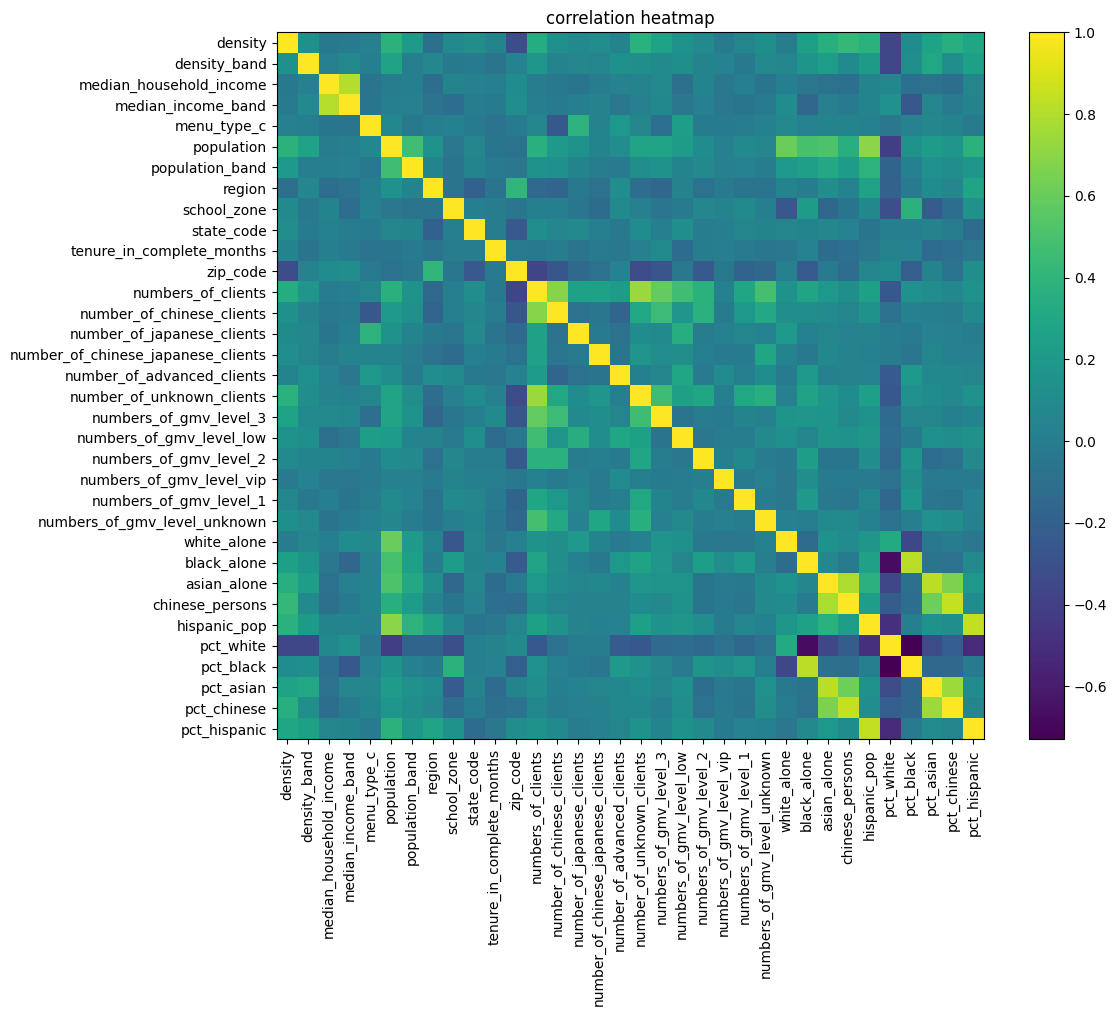

In [17]:
# 1. compute correlation matrix
corr = tenure_data_encoded.corr()

# 2. create the plot
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(corr, aspect='equal')

# 3. set tick labels
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns)

# 4. add colorbar and title
plt.colorbar(cax, ax=ax)
ax.set_title('correlation heatmap')

# 5. tidy layout and show
plt.tight_layout()
plt.show()

Feature selection:

In [18]:
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer
from sklearn.preprocessing      import OrdinalEncoder
from sklearn.ensemble           import RandomForestRegressor
from sklearn.feature_selection  import SelectFromModel

# 1. drop rows with missing target
target = "tenure_in_complete_months"
df_clean  = tenure_data_no_id.dropna(subset=[target])

# 2. define X and y on the cleaned DataFrame
X_raw = df_clean.drop(columns=[target])
y_raw = df_clean[target]

# 3. split numeric vs. categorical
num_cols = X_raw.select_dtypes(include="number").columns.tolist()
cat_cols = X_raw.select_dtypes(exclude="number").columns.tolist()

# 4. build preprocessing + feature‐selection pipeline
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OrdinalEncoder(),   cat_cols),
])
fs_pipeline = Pipeline([
    ("pre", preprocessor),
    ("sel", SelectFromModel(
        RandomForestRegressor(n_estimators=200, random_state=42),
        threshold="median"
    )),
])

# 5. fit on the cleaned data
fs_pipeline.fit(X_raw, y_raw)

# 6. extract selected features
mask           = fs_pipeline.named_steps["sel"].get_support()
all_features   = num_cols + cat_cols
selected_feats = [f for f, keep in zip(all_features, mask) if keep]

print(f"Selected {len(selected_feats)} features:\n", selected_feats)

Selected 17 features:
 ['density', 'population', 'white_alone', 'black_alone', 'asian_alone', 'chinese_persons', 'hispanic_pop', 'pct_white', 'pct_black', 'pct_asian', 'pct_chinese', 'pct_hispanic', 'median_household_income', 'menu_type_c', 'school_zone', 'state_code', 'zip_code']
